![title](book-birds.png)

<h1>CSCA 5642 Final Project: Are You My Mother?</h1>

<h2>Problem, Goals and Data</h2>

I was inspired for the final project by the classic children's book "Are You My Mother?" (You can read it in PDF format [here](https://readwj.wordpress.com/wp-content/uploads/2023/03/are-you-my-mother.pdf); it's very short.) In this story, a baby bird loses track of its mother and approaches various members of its community — a kitten, a hen, a dog, a cow, a boat, a plane and a digger — asking each, "Are you my mother?" Eventually it finds its mother again and all is well.

This little bird could have saved itself some trouble with a neural network trained on birds! 

So that's what I'd like to create. My goal is to build a model that, given two input images — one of a baby bird, one of anything else — can make two predictions. 

First, it will predict whether the second photo is of a bird. If not, it will tell the baby bird the second photo is not its mother.

Second, if the second photo is determined to be a bird, it will predict whether it is the same kind as the baby bird, and thus could be its mother. This second step is necessary because in the text, one of the potential mothers the baby bird approached was a hen. That's a bird, but not the right kind.

I will use two datasets to train this model. The first is a great, very large and well labeled dataset of male, female and juvenile birds from the Cornell Lab of Ornithology, available [here](https://dl.allaboutbirds.org/nabirds). This will help our model in its second step of determining whether a baby and adult bird are the same kind. 

The model will also need some training images of things other than  birds to help with its first step — determining whether the second input image is even a bird at all. I'll use the well-known [CIFAR 100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) from the University of Toronto for this task. A big advantage of this dataset is that its 20 superclasses of image types include lots of reasonable proxies for the kinds of non-birds the baby bird in the story approaches, but it does not include birds, so I won't have to find and exclude them.

We'll start by importing some useful libraries and both datasets.

In [1]:
#import some useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import math
import pickle
import gzip
from PIL import Image
from tqdm.notebook import tqdm
import tensorflow as tf
import os
import random
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import Cropping2D

#load the birds data
dir_bird = '/Users/206509/CU/machine-learning/deep-learning/birds/images'

#load the non-birds data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

not_bird_test = unpickle('/Users/206509/CU/machine-learning/deep-learning/birds/cifar-100-python/test')
not_bird_train = unpickle('/Users/206509/CU/machine-learning/deep-learning/birds/cifar-100-python/train')
not_bird_meta = unpickle('/Users/206509/CU/machine-learning/deep-learning/birds/cifar-100-python/train')

<h2>Exploratory Data Analysis</h2>

<h3>Birds Data Overview</h3>

The `birds` data directory is fairly complex. It includes a folder, `images`, of image files organized into 555 subdirectories based on species. In total, the species subdirectories contain about 48,500 images. It also includes a text list, `classes.txt`, that provides labels for the 555 subdirectories in the images folder. The list of image file names is included in a text list, `images.txt`, with each line corresponding to one image: _image_id, image_name_. 

The directory also contains a suggested training/test split, which is very nice. It is contained the file `train_test_split.txt`, with each line corresponding to one image: _image_id, is_training_image_. A 1 value for _is_training_image_ corresponds to a training image, and a 0 for test images. 

The file `sizes.txt` contains each _image_id_, followed by its width and height in pixels. And `photographers.txt` contains each _image_id_ plus the photographer's name who took the photo. Lastly, there's a helpful starter code file, `nabirds.py`, for pulling down each aspect of the `birds` directory. I will use some of that code below.

There are a few aspects of the birds data directory that we will not use for this project, but that would be useful for future projects drilling down more specifically on bird classification or similar goals. They include some files related to bird parts (e.g., wing, beak): a directory, a list of names and a list of locations within images for the parts. There is also a class hierarchy text file, which rolls species names up into larger categories (e.g., a Tyrant Flycatcher belongs to the Perching Birds class). Since we're focused on a species-level analysis here, we don't need to worry about this hierarchy either. Lastly, there is a `bounding_boxes.txt` file that lists the locations of bounding boxes within the photos; we're not getting that granular with the images here, but it could be useful for a future, more sophisticated version of this model.

<h3>Non-Birds Data Overview</h3>

The `not-bird` data is organized into three files: a `train` and `test` file, plus a `meta` file. The `train` and `test` file each contain a dictionary with two elements. The first is `data`, a 10000x3072 numpy array of uint8s. As outlined on the UT site where they are hosted (see references): "Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image." The second element in the dictionary is `labels`, defined as "a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data." 

There is an additional file, `meta`. It's another dictionary that contains label names for the array values in `labels`. (For example, "label_names[0] == "airplane", label_names[1] == "automobile", etc.) I don't think we'll use this, because we're only using this to train our model on what non-birds might look like. But it could be useful for a future version of the project in which the model can predict what non-bird items are.

Our first step will be to import and organize all of the different files in the `birds` directory AND the `not-bird` directory into a single dataframe we can work with. Then we can inspect it.

<h3>Importing and Inspecting the Birds Data</h3>

In [2]:
#load all the different txt files as pandas dataframes with consistent column headers:
#images
images_df = pd.read_csv('/Users/206509/CU/machine-learning/deep-learning/birds/images.txt', sep=r'\s+|/', engine='python',
                        header=None, names=['image_id', 'species_id', 'filename'])
#train/test 
train_test_df = pd.read_csv('/Users/206509/CU/machine-learning/deep-learning/birds/train_test_split.txt', sep=r'\s+', 
                            header=None, names=['image_id', 'is_training_image'])
#sizes
sizes_df = pd.read_csv('/Users/206509/CU/machine-learning/deep-learning/birds/sizes.txt', sep=r'\s+', 
                       header=None, names=['image_id', 'width', 'height'])
#photographers (a little fussier because the photographers' names have spaces, sometimes multiple spaces)
photographers = []
with open('/Users/206509/CU/machine-learning/deep-learning/birds/photographers.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(' ', 1)  #split only at the first space
        photographers.append(parts)
photographers_df = pd.DataFrame(photographers, columns=['image_id', 'photographer'])
#species (also a little fussier for the same reason, species names may have multiple spaces)
species = []
with open('/Users/206509/CU/machine-learning/deep-learning/birds/classes.txt', 'r') as g:
    for line in g:
        parts = line.strip().split(' ', 1)  #split only at the first space
        if len(parts) == 2: 
            species_id = int(parts[0])
            species_name = parts[1]
            species.append([species_id, species_name])
species_df = pd.DataFrame(species, columns=['species_id', 'species_name'])

#merge all into a single dataframe
bird_df = pd.merge(images_df, train_test_df, on='image_id')
bird_df = pd.merge(bird_df, sizes_df, on='image_id')
bird_df = pd.merge(bird_df, photographers_df, on='image_id')
bird_df = pd.merge(bird_df, species_df, on='species_id')

#add image paths, taking subcategories into account
bird_df['image_path'] = bird_df.apply(lambda row: os.path.join('/Users/206509/CU/machine-learning/deep-learning/birds/images', 
        str(row['species_id']).zfill(4),  row['filename']), axis=1)

print(bird_df.head())

                               image_id  species_id  \
0  0000139e-21dc-4d0c-bfe1-4cae3c85c829         817   
1  0000d9fc-4e02-4c06-a0af-a55cfb16b12b         860   
2  00019306-9d83-4334-b255-a447742edce3         900   
3  0001afd4-99a1-4a67-b940-d419413e23b3         645   
4  000332b8-997c-4540-9647-2f0a8495aecf         929   

                               filename  is_training_image  width  height  \
0  0000139e21dc4d0cbfe14cae3c85c829.jpg                  0    296     341   
1  0000d9fc4e024c06a0afa55cfb16b12b.jpg                  0    640     427   
2  000193069d834334b255a447742edce3.jpg                  0    730    1024   
3  0001afd499a14a67b940d419413e23b3.jpg                  1   1024     680   
4  000332b8997c454096472f0a8495aecf.jpg                  0   1024     682   

                      photographer                        species_name  \
0                    Ruth Cantwell                        Oak Titmouse   
1  Christopher L. Wood, Chris Wood                        

<h2>Importing and Inspecting the Non-Bird Data</h2>

In [3]:
#we know the images are stored as arrays so we'll store an image reshaper for later
def reshape_image(image_array):
    return image_array.reshape(3, 32, 32).transpose(1, 2, 0)

#check out the structure of the dictionaries
print("Train keys:", not_bird_train.keys())
print("Test keys:", not_bird_test.keys())

#restructure train and test dicts into dataframes
non_bird_train_df = pd.DataFrame({
    'image_id': np.arange(len(not_bird_train[b'data'])),
    'image_array': [reshape_image(img) for img in not_bird_train[b'data']],
    'fine_label': not_bird_train[b'fine_labels'], 
    'filename': not_bird_train[b'filenames']})

non_bird_test_df = pd.DataFrame({
    'image_id': np.arange(len(not_bird_test[b'data'])),
    'image_array': [reshape_image(img) for img in not_bird_test[b'data']],
    'fine_label': not_bird_test[b'fine_labels'],
    'filename': not_bird_test[b'filenames']})

#add training column 
non_bird_train_df['is_training_image'] = 1  
non_bird_test_df['is_training_image'] = 0 

non_bird_df = pd.concat([non_bird_train_df, non_bird_test_df], ignore_index=True)

print(non_bird_df.tail())

Train keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
Test keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
       image_id                                        image_array  \
59995      9995  [[[158, 162, 120], [118, 179, 62], [78, 165, 5...   
59996      9996  [[[100, 121, 56], [113, 132, 72], [130, 151, 8...   
59997      9997  [[[24, 38, 31], [24, 40, 31], [22, 34, 28], [1...   
59998      9998  [[[86, 90, 80], [93, 90, 75], [28, 25, 21], [4...   
59999      9999  [[[246, 246, 242], [240, 238, 232], [214, 212,...   

       fine_label                        filename  is_training_image  
59995          83    b'sweet_pepper_s_000390.png'                  0  
59996          14  b'mourning_cloak_s_001020.png'                  0  
59997          51        b'mushroom_s_001698.png'                  0  
59998          42         b'leopard_s_001238.png'                  0  
59999          70            b'

I printed the tail here because I wanted to be sure of something — `image_id` is also a feature in the `bird_df`, and I wanted to be sure there wouldn't be any overlap when we concatenate them. The `image_id` for non-birds is a number up to four digits, whereas the `image_id`s for the birds are much longer mixed strings, so I think we'll be fine there. Let's print some summary stats to have available to sanity-check the concatentation later.

In [4]:
print("Bird info:\n")
print(bird_df.info())
print("Non-bird info:\n")
print(non_bird_df.info())

Bird info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48562 entries, 0 to 48561
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           48562 non-null  object
 1   species_id         48562 non-null  int64 
 2   filename           48562 non-null  object
 3   is_training_image  48562 non-null  int64 
 4   width              48562 non-null  int64 
 5   height             48562 non-null  int64 
 6   photographer       48562 non-null  object
 7   species_name       48562 non-null  object
 8   image_path         48562 non-null  object
dtypes: int64(4), object(5)
memory usage: 3.3+ MB
None
Non-bird info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           60000 non-null  int64 
 1   image_array        60000 non-null  obj

<h2>Combining the Bird and Non-Bird Dataframes</h2>

There are a couple of things left to do before we can combine the dataframes. First, we should add an "is_bird" column to both dfs before combining. 

Second, we should standardize how the images are being handled. The bird images are still being passed as filepaths, while the non-bird images are NumPy arrays. We can handle this by turning the bird images into NumPy arrays too. We should standardize the size while we're at it: Crop the images square (most of them currently are not) and then resize them to 32x32 pixels. (The non-bird images are already standardized at 32x32 pixels.) This cell takes a while to run because there are 48,500 non-bird images to get through.

In [5]:
bird_df['is_bird'] = 1
non_bird_df['is_bird'] = 0

print("Bird info:\n")
print(bird_df.info())
print("Non-bird info:\n")
print(non_bird_df.info())

Bird info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48562 entries, 0 to 48561
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           48562 non-null  object
 1   species_id         48562 non-null  int64 
 2   filename           48562 non-null  object
 3   is_training_image  48562 non-null  int64 
 4   width              48562 non-null  int64 
 5   height             48562 non-null  int64 
 6   photographer       48562 non-null  object
 7   species_name       48562 non-null  object
 8   image_path         48562 non-null  object
 9   is_bird            48562 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 3.7+ MB
None
Non-bird info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           60000 non-null  in

In [6]:
def load_and_preprocess_image(image_path):
    """Load and preprocess the image from the given path."""
    try:
        # Check if the image path exists
        if not os.path.exists(image_path):
            print(f"Image does not exist: {image_path}")
            return np.zeros((32, 32, 3))  #return a default array on error (same strategy also used later)
        image = Image.open(image_path)
        
        width, height = image.size
        
        #cropping box to get the center of the image
        min_dim = min(width, height)
        left = (width - min_dim) // 2
        upper = (height - min_dim) // 2
        right = left + min_dim
        lower = upper + min_dim
        
        #crop the image
        image = image.crop((left, upper, right, lower))

        #resize to 32x32 and convert to a numpy array
        image = image.resize((32, 32))
        image_array = np.array(image)  
        return image_array
        
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return np.zeros((32, 32, 3)) 
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros((32, 32, 3))  

#apply the function to a copy of the bird df
bird_df_copy = bird_df.copy()
bird_df_copy.loc[:, 'image_array'] = bird_df_copy['image_path'].apply(load_and_preprocess_image)

#show the head of the processed df
print(bird_df_copy[['image_path', 'image_array']].tail())

                                              image_path  \
48557  /Users/206509/CU/machine-learning/deep-learnin...   
48558  /Users/206509/CU/machine-learning/deep-learnin...   
48559  /Users/206509/CU/machine-learning/deep-learnin...   
48560  /Users/206509/CU/machine-learning/deep-learnin...   
48561  /Users/206509/CU/machine-learning/deep-learnin...   

                                             image_array  
48557  [[[75, 94, 126], [73, 94, 127], [74, 93, 127],...  
48558  [[[102, 112, 116], [120, 129, 135], [136, 146,...  
48559  [[[90, 109, 124], [89, 108, 123], [88, 109, 12...  
48560  [[[176, 165, 111], [179, 166, 116], [181, 169,...  
48561  [[[169, 168, 150], [153, 144, 132], [136, 122,...  


In [7]:
#combine both dfs
df = pd.concat([bird_df_copy, non_bird_df], ignore_index=True)

#show head and tail
print(df.head())

                               image_id  species_id  \
0  0000139e-21dc-4d0c-bfe1-4cae3c85c829       817.0   
1  0000d9fc-4e02-4c06-a0af-a55cfb16b12b       860.0   
2  00019306-9d83-4334-b255-a447742edce3       900.0   
3  0001afd4-99a1-4a67-b940-d419413e23b3       645.0   
4  000332b8-997c-4540-9647-2f0a8495aecf       929.0   

                               filename  is_training_image   width  height  \
0  0000139e21dc4d0cbfe14cae3c85c829.jpg                  0   296.0   341.0   
1  0000d9fc4e024c06a0afa55cfb16b12b.jpg                  0   640.0   427.0   
2  000193069d834334b255a447742edce3.jpg                  0   730.0  1024.0   
3  0001afd499a14a67b940d419413e23b3.jpg                  1  1024.0   680.0   
4  000332b8997c454096472f0a8495aecf.jpg                  0  1024.0   682.0   

                      photographer                        species_name  \
0                    Ruth Cantwell                        Oak Titmouse   
1  Christopher L. Wood, Chris Wood                  

In [8]:
#drop filepath, width and height columns now that we've processed all the bird images into numpy arrays
df = df.drop(['width', 'height', 'image_path'], axis=1)

print(df.head())
print(df.info())

                               image_id  species_id  \
0  0000139e-21dc-4d0c-bfe1-4cae3c85c829       817.0   
1  0000d9fc-4e02-4c06-a0af-a55cfb16b12b       860.0   
2  00019306-9d83-4334-b255-a447742edce3       900.0   
3  0001afd4-99a1-4a67-b940-d419413e23b3       645.0   
4  000332b8-997c-4540-9647-2f0a8495aecf       929.0   

                               filename  is_training_image  \
0  0000139e21dc4d0cbfe14cae3c85c829.jpg                  0   
1  0000d9fc4e024c06a0afa55cfb16b12b.jpg                  0   
2  000193069d834334b255a447742edce3.jpg                  0   
3  0001afd499a14a67b940d419413e23b3.jpg                  1   
4  000332b8997c454096472f0a8495aecf.jpg                  0   

                      photographer                        species_name  \
0                    Ruth Cantwell                        Oak Titmouse   
1  Christopher L. Wood, Chris Wood                            Ovenbird   
2                      Ryan Schain                    Savannah Sparrow   


We'll need the `species_id` values to be integers later on, but the concatenation turned them into floats because there are 60,000 null values for all the non-bird images. Let's integerize the other values and use a filler `-1` value for the non-bird images.

In [9]:
df['species_id'] = pd.to_numeric(df['species_id'], errors='coerce').fillna(0).astype(int)
df['species_id'] = df['species_id'].replace(0, -1)
df['species_id'].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108562 entries, 0 to 108561
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   image_id           108562 non-null  object 
 1   species_id         108562 non-null  int64  
 2   filename           108562 non-null  object 
 3   is_training_image  108562 non-null  int64  
 4   photographer       48562 non-null   object 
 5   species_name       48562 non-null   object 
 6   is_bird            108562 non-null  int64  
 7   image_array        108562 non-null  object 
 8   fine_label         60000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 7.5+ MB


Now the dataframe looks just like we'd expect it to: files from the `birds` dataset are at the top (and the `non-birds`-only features are empty) and files from the `non-birds` dataset are at the bottom (and the `birds`-only features are empty). And there are 108,562 total rows, just as there should be — we didn't accidentally combine any bird and non-bird rows where we shouldn't have.

One last thing — let's scale the pixel values in the image arrays on a (0,1) scale.

In [10]:
#define a function to rescale the image arrays
def rescale_image_array(image_array):
    return image_array / 255.0

#apply the function to the entire 'image_array' column in the dataframe
df['image_array'] = df['image_array'].apply(rescale_image_array)

print(df['image_array'].head())

0    [[[0.27058823529411763, 0.2549019607843137, 0....
1    [[[0.4745098039215686, 0.6235294117647059, 0.1...
2    [[[0.4235294117647059, 0.4392156862745098, 0.4...
3    [[[0.40784313725490196, 0.4627450980392157, 0....
4    [[[0.6823529411764706, 0.7019607843137254, 0.7...
Name: image_array, dtype: object


In [11]:
#make sure all the image arrays have the expected shape
shapes = df['image_array'].apply(lambda x: x.shape)
print("Shapes of images in training data:")
print(shapes.value_counts())  # This will give you a count of unique shapes

# Print the actual shapes for confirmation
for index, shape in enumerate(shapes):
    if shape != (32, 32, 3):
        print(f"Index: {index}, Shape: {shape}")

Shapes of images in training data:
image_array
(32, 32, 3)    108561
(32, 32, 4)         1
Name: count, dtype: int64
Index: 11180, Shape: (32, 32, 4)


In [12]:
#one row seems to have a mistaken shape; let's inspect it
shape_problem = df.at[11180, 'image_array']
print(shape_problem)

[[[0.52941176 0.58431373 0.67058824 1.        ]
  [0.54509804 0.60784314 0.69803922 1.        ]
  [0.54509804 0.60392157 0.70196078 1.        ]
  ...
  [0.48235294 0.56862745 0.67843137 1.        ]
  [0.47058824 0.55686275 0.6627451  1.        ]
  [0.4627451  0.54901961 0.64705882 1.        ]]

 [[0.38039216 0.43921569 0.52156863 1.        ]
  [0.38823529 0.44705882 0.53333333 1.        ]
  [0.39215686 0.45490196 0.54901961 1.        ]
  ...
  [0.47058824 0.54509804 0.64705882 1.        ]
  [0.49019608 0.56078431 0.6627451  1.        ]
  [0.49411765 0.55686275 0.65882353 1.        ]]

 [[0.41568627 0.49019608 0.58823529 1.        ]
  [0.43921569 0.51372549 0.60784314 1.        ]
  [0.42745098 0.50980392 0.60392157 1.        ]
  ...
  [0.42745098 0.48627451 0.58431373 1.        ]
  [0.44705882 0.51764706 0.61568627 1.        ]
  [0.45098039 0.51764706 0.62352941 1.        ]]

 ...

 [[0.42352941 0.49019608 0.59607843 1.        ]
  [0.41960784 0.49019608 0.60392157 1.        ]
  [0.39215

In [13]:
reshaped_image = shape_problem[:, :, :3]  # keep only the first three channels

#update df
df.at[11180, 'image_array'] = reshaped_image

shapes = df['image_array'].apply(lambda x: x.shape)
print("Shapes of images in training data:")
print(shapes.value_counts())

for index, shape in enumerate(shapes):
    if shape != (32, 32, 3):
        print(f"Index: {index}, Shape: {shape}")

Shapes of images in training data:
image_array
(32, 32, 3)    108562
Name: count, dtype: int64


Great, now we have the right shape for all 108,562 images.

<h2>Data Visualization</h2>

Now that we have our big, beautiful dataframe with everything we need from both the `birds` and `non-birds` datasets, let's do some visualization. We have a total of eight factors: `image_id`, `image_array`, `filename`, `is_bird` and `is_training_image` (for both birds and non-birds), `species_id`, `photographer`, and `species_name` (for birds only) and `fine_label` (for non-birds only).

I am not particularly worried about correlation because basically all of these factors are categorical or binary. But there are still a few visualizations we can do. We can see how many training vs. test images there are for birds vs. non-birds, for instance. It would also be nice to see some examples of the images our model will be training on. 

The birds dataset terms of use request that the photographer name be displayed when the image is printed, so we'll include it. :)

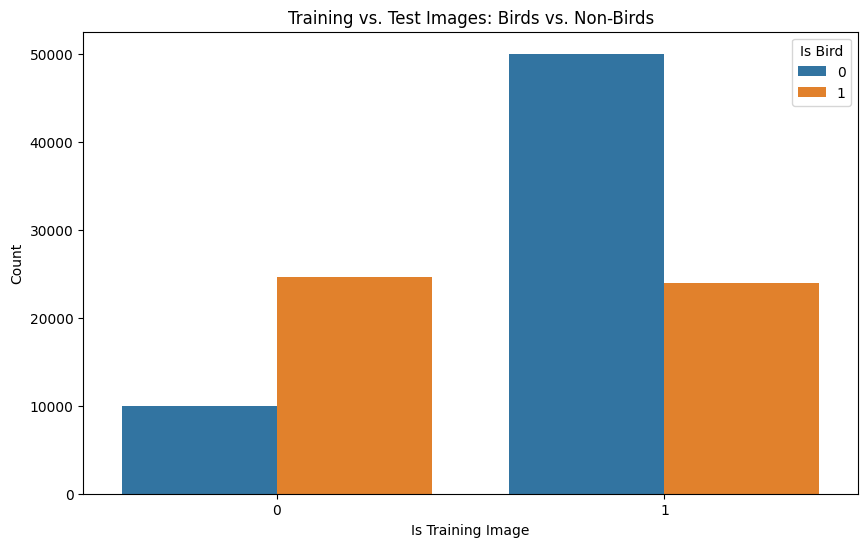

In [14]:
#distribution of training vs. test images for birds vs. non-birds
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='is_training_image', hue='is_bird')
plt.title('Training vs. Test Images: Birds vs. Non-Birds')
plt.xlabel('Is Training Image')
plt.ylabel('Count')
plt.legend(title='Is Bird')
plt.show()

Okay, good to know — the training/test split for non-birds is 50000/10000 and for birds it's evenly split at about 24,000 of each type. I think we can live with this because our model works in two parts, `is/is not bird` and then `species`. We'll just need to be careful in the first training section to account for the imbalance between bird images (48,500) and non-bird images (60,000).

Next, let's see a few random training images from both sets and then the distribution of how many images there are per species.

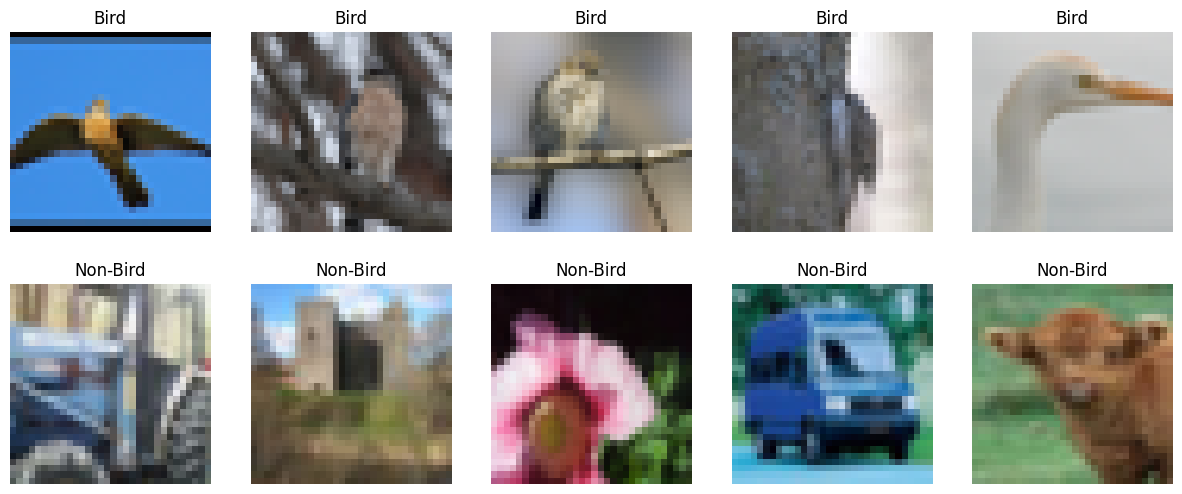

In [15]:
import random
from matplotlib import pyplot as plt

#select random bird and non-bird training images
bird_images = df[(df['is_bird'] == 1) & (df['is_training_image'] == 1)].sample(5)
non_bird_images = df[(df['is_bird'] == 0) & (df['is_training_image'] == 1)].sample(5)

#plot some example images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, (bird_row, non_bird_row) in enumerate(zip(bird_images.iterrows(), non_bird_images.iterrows())):
    bird_image = bird_row[1]['image_array']
    non_bird_image = non_bird_row[1]['image_array']
    
    # Bird images (first row)
    axs[0, i].imshow(bird_image)
    axs[0, i].axis('off')
    axs[0, i].set_title('Bird')
    
    # Non-bird images (second row)
    axs[1, i].imshow(non_bird_image)
    axs[1, i].axis('off')
    axs[1, i].set_title('Non-Bird')

plt.show()

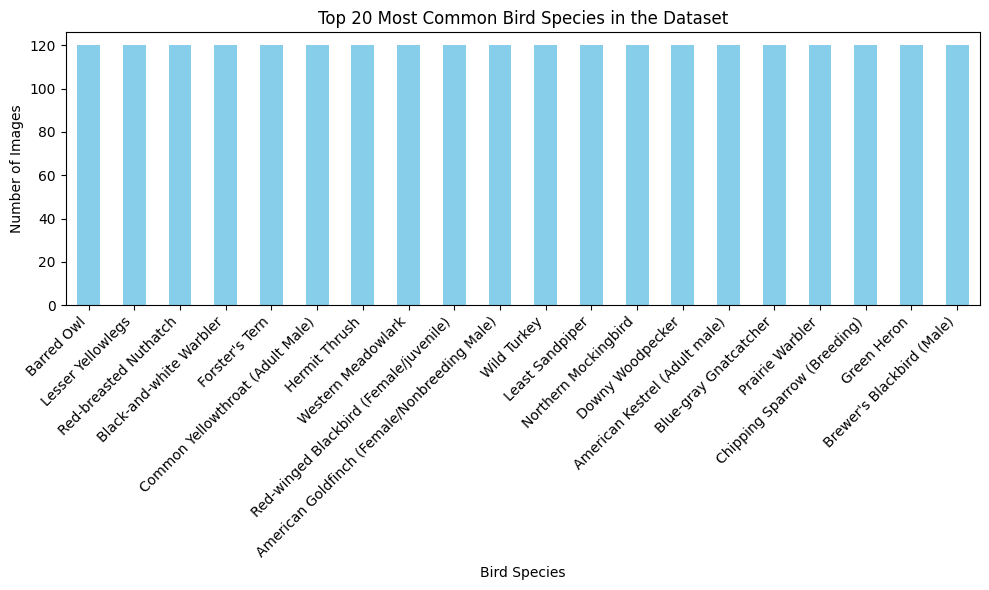

In [16]:
bird_df = df[df['is_bird'] == True]

#group by reclassified species and count the number of images per species
species_counts = bird_df['species_name'].value_counts()
top_10_species = species_counts.head(20)

#plot a bar chart
plt.figure(figsize=(10, 6))
top_10_species.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Common Bird Species in the Dataset')
plt.xlabel('Bird Species')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Wow, very evenly distributed! Interesting!

<h2>Model Architecture</h2>

I would like to write a program that takes as input two images: one image of a baby bird, and one image of anything else. The model will work in two steps. First, it will examine the second image to see if it is a bird. If it is predicts that it is not a bird, it will return "This is not your mother; it is not a bird." 

If the second image is a bird, the model will then compare it with the first image to see if they are the same species. If it predicts that they are not the same species, it will return "This is not your mother, you are a {species prediction for first image} and it is probably a {species prediction for second image}." If it predicts that they are the same species, it will return "This might be your mother! It is a {species prediction, matching for both images}, just like you."

I'd like to go about this task using two separate models: binary classification (for the "bird or not?" step) using a CNN, with sigmoid classification at the output layer because it's a binary result. And secondly, multiclass classification (for the species prediction for both images) using a separate CNN architecture with a softmax layer.

We'll start by building and training our two models.

<h3>First Model: Building a Binary Classification ("Bird or Not?") CNN</h3>

In [17]:
def create_bird_or_not_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  #binary classification
    return model

bird_or_not_model = create_bird_or_not_model()
bird_or_not_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<h3>Training the Bird-or-Not Model</h3>

In [18]:
train_data = df[df['is_training_image'] == True]
test_data = df[df['is_training_image'] == False]

#prep training data for the bird-or-not model
X_train_bird_not = np.stack(train_data['image_array'].values)
y_train_bird_not = train_data['is_bird'].values

#train the bird-or-not model
bird_or_not_history = bird_or_not_model.fit(X_train_bird_not, 
                                            y_train_bird_not, epochs=10, batch_size=32, validation_split=0.2)

bird_or_not_train_acc = bird_or_not_history.history['accuracy']
bird_or_not_val_acc = bird_or_not_history.history['val_accuracy']

Epoch 1/10
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7374 - loss: 0.5057 - val_accuracy: 0.9542 - val_loss: 0.1200
Epoch 2/10
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8906 - loss: 0.2655 - val_accuracy: 0.8626 - val_loss: 0.3173
Epoch 3/10
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9095 - loss: 0.2271 - val_accuracy: 0.9790 - val_loss: 0.0526
Epoch 4/10
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9176 - loss: 0.2078 - val_accuracy: 0.9476 - val_loss: 0.1251
Epoch 5/10
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9274 - loss: 0.1849 - val_accuracy: 0.9664 - val_loss: 0.0882
Epoch 6/10
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9348 - loss: 0.1666 - val_accuracy: 0.9148 - val_loss: 0.2151
Epoch 7/10
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9373 - loss: 0.1572 - val_accuracy: 0.9377 - val_loss: 0.1566
Epoch 8/10
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9409 - loss: 0

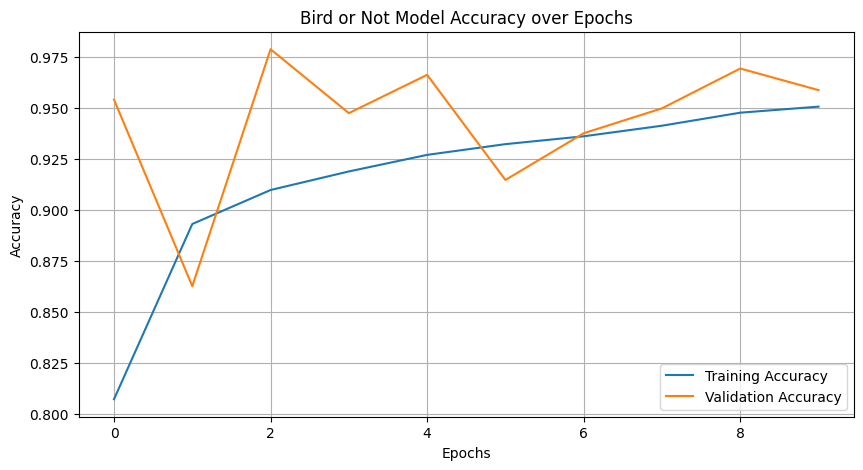

In [19]:
def plot_accuracy(train_acc, val_acc, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

#accuracy for bird-or-not model
plot_accuracy(bird_or_not_train_acc, bird_or_not_val_acc, 'Bird or Not Model')

This is looking really promising, but I'm not 100 percent sure it converged. Let's do a little hyperparameter tuning — we can add more epochs (and an early stopping callback in case that's too many), and also use a lower validation split to give us more training data to work with. I feel comfortable doing that here since the validation accuracy was so high across all the epochs.

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

#tuned bird-or-not model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

bird_or_not_history_v2 = bird_or_not_model.fit(X_train_bird_not, 
                                            y_train_bird_not, epochs=15, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

bird_or_not_train_acc_v2 = bird_or_not_history_v2.history['accuracy']
bird_or_not_val_acc_v2 = bird_or_not_history_v2.history['val_accuracy']

Epoch 1/15
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9609 - loss: 0.1020 - val_accuracy: 0.9122 - val_loss: 0.2370
Epoch 2/15
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9641 - loss: 0.0917 - val_accuracy: 0.9597 - val_loss: 0.1054
Epoch 3/15
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9666 - loss: 0.0847 - val_accuracy: 0.9424 - val_loss: 0.1589
Epoch 4/15
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9709 - loss: 0.0748 - val_accuracy: 0.9527 - val_loss: 0.1230
Epoch 5/15
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9751 - loss: 0.0654 - val_accuracy: 0.9721 - val_loss: 0.0850
Epoch 6/15
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9744 - loss: 0.0640 - val_accuracy: 0.9544 - val_loss: 0.1382
Epoch 7/15
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9782 - loss: 0.0564 - val_accuracy: 0.9671 - val_loss: 0.1016
Epoch 8/15
2080/2080 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9792 - loss: 

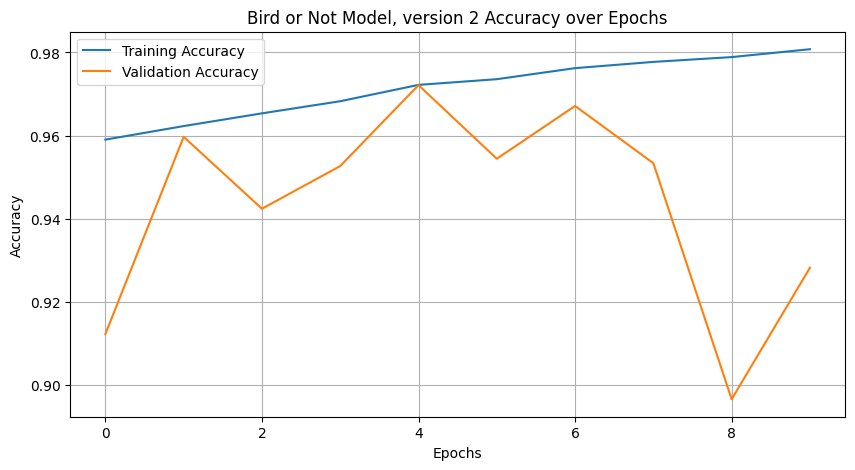

In [24]:
#plot accuracy for tuned bird-or-not model
plot_accuracy(bird_or_not_train_acc_v2, bird_or_not_val_acc_v2, 'Bird or Not Model, version 2')

Great, this is even better. We'll use this as our final contender for bird-or-not binary classification. Let's test it using the test data and plot a confusion matrix:

In [27]:
from sklearn.metrics import confusion_matrix

test_data = df[df['is_training_image'] == False]

print(test_data['is_bird'].value_counts())

X_test_bird_not = np.stack(test_data['image_array'].values)
y_test_bird_not = test_data['is_bird'].values
test_preds = bird_or_not_model.predict(X_test_bird_not)
threshold = 0.5
test_preds_binary = (test_preds > threshold).astype(int)

confusion_matrix(y_test_bird_not, test_preds_binary)


is_bird
1    24633
0    10000
Name: count, dtype: int64
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


array([[ 9718,   282],
       [ 4315, 20318]])

Okay, we'll take it! Precision is almost 90 percent, recall is about 83 percent. If we had more time, we might want to try to improve these, but I think we can live with them for this project.

<h3>Second Model: Building a Multiclass Classification (Species Prediction) Softmax CNN</h3>

In [28]:
df['species_id'] = df['species_id'].replace(-1,np.nan)

In [29]:
num_species = len(df['species_id'].value_counts())

def create_species_prediction_model(num_species):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_species, activation='softmax'))  #multi-class classification
    return model

species_prediction_model = create_species_prediction_model(num_species)
species_prediction_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<h3>Training the Species Prediction Model</h3>

One quick thing about the species data: all the values in `species_id` are three digits that encode meaning in a way we don't care about (using the class hierarchy): i.e., 960, 798, etc. It would be better to encode them continuously (0 to 554) because that's what the CNN will be expecting to work with. We'll make that change now in the training stage.

In [30]:
#prep training data for species prediction (only for birds)
train_bird_data = train_data[train_data['is_bird'] == 1]

#stack image arrays
X_train_species = np.stack(train_bird_data['image_array'].values)

#create a mapping from original species_id to a continuous range
unique_species_ids = train_bird_data['species_id'].unique()
species_id_mapping = {id_: idx for idx, id_ in enumerate(unique_species_ids)}
y_train_species = train_bird_data['species_id'].map(species_id_mapping)

#convert to categorical format
num_species = len(species_id_mapping)
y_train_species = tf.keras.utils.to_categorical(y_train_species, num_classes=num_species)

#train the species prediction model
species_prediction_history = species_prediction_model.fit(X_train_species, y_train_species, epochs=10, batch_size=8, validation_split=0.2)

Epoch 1/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0028 - loss: 6.2954 - val_accuracy: 0.0040 - val_loss: 6.1193
Epoch 2/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0075 - loss: 6.0278 - val_accuracy: 0.0079 - val_loss: 5.9104
Epoch 3/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0153 - loss: 5.8025 - val_accuracy: 0.0159 - val_loss: 5.7330
Epoch 4/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0229 - loss: 5.5781 - val_accuracy: 0.0232 - val_loss: 5.6083
Epoch 5/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0346 - loss: 5.3241 - val_accuracy: 0.0330 - val_loss: 5.4732
Epoch 6/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0518 - loss: 5.0850 - val_accuracy: 0.0322 - val_loss: 5.5718
Epoch 7/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.0723 - loss: 4.8667 - val_accuracy: 0.0412 - val_loss: 5.4212
Epoch 8/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.0912 - loss: 4

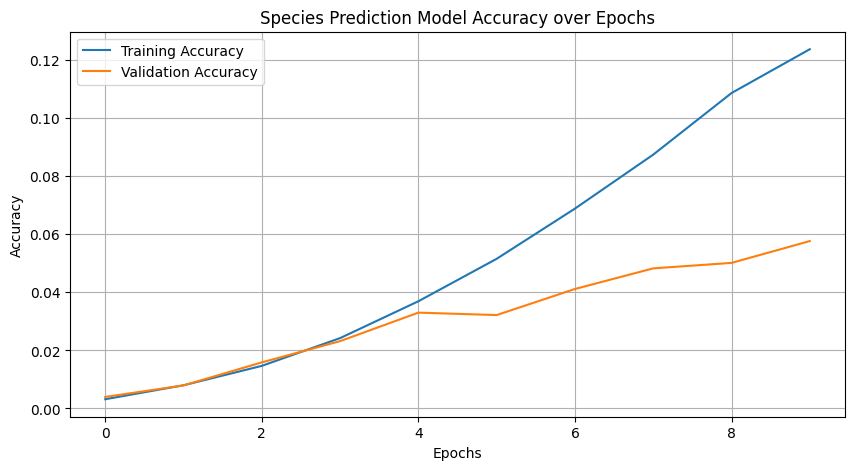

In [31]:
#store and plot these results
species_prediction_train_acc = species_prediction_history.history['accuracy']
species_prediction_val_acc = species_prediction_history.history['val_accuracy']
plot_accuracy(species_prediction_train_acc, species_prediction_val_acc, 'Species Prediction Model')

Oof! That is very painful. We can try it with more epochs and a bigger batch size …

In [32]:
species_prediction_history_v2 = species_prediction_model.fit(X_train_species, 
                                                             y_train_species, epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40
599/599 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1927 - loss: 3.8717 - val_accuracy: 0.0612 - val_loss: 5.7670
Epoch 2/40
599/599 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1993 - loss: 3.7624 - val_accuracy: 0.0637 - val_loss: 5.8414
Epoch 3/40
599/599 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2199 - loss: 3.6436 - val_accuracy: 0.0612 - val_loss: 5.8917
Epoch 4/40
599/599 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2451 - loss: 3.5050 - val_accuracy: 0.0664 - val_loss: 6.0268
Epoch 5/40
599/599 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2642 - loss: 3.3974 - val_accuracy: 0.0637 - val_loss: 6.1326
Epoch 6/40
599/599 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2849 - loss: 3.2736 - val_accuracy: 0.0637 - val_loss: 6.3549
Epoch 7/40
599/599 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3057 - loss: 3.1416 - val_accuracy: 0.0616 - val_loss: 6.5629
Epoch 8/40
599/599 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3297 - loss: 3.0075 - val_accu

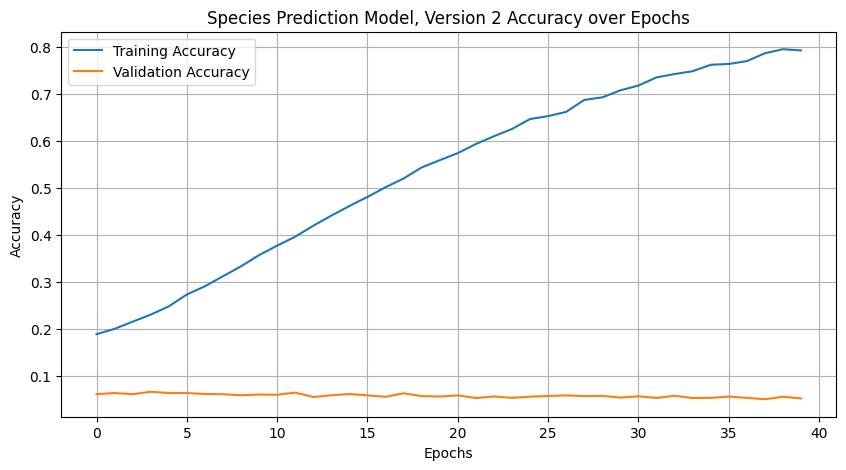

In [33]:
#store and plot these results
species_prediction_train_acc_v2 = species_prediction_history_v2.history['accuracy']
species_prediction_val_acc_v2 = species_prediction_history_v2.history['val_accuracy']
plot_accuracy(species_prediction_train_acc_v2, species_prediction_val_acc_v2, 'Species Prediction Model, Version 2')

Well, this is just textbook overfitting! The test accuracy continued to improve a _bit_ up through epoch 18, but then it was downhill again, and it never got very high in the first place — not even breaking 10 percent.

I think this is probably because although we have a lot of data, we also have a _lot_ of categories — 555 is a lot! — and a quirk of the data I hadn't yet contended with is that some of the categories are subcategories of others: e.g., "179 Common Eider" "295 Common Eider (Adult male)" "463 Common Eider (Female/juvenile)" and "696 Common Eider (Immature/Eclipse male)".

We'll need to rethink this!

<h3>Restructuring the Birds Data</h3>

I had initially put aside the file called `hierarchy.txt` that rolls up all the species into higher-level orderings because I thought we could use all the species, but I think it would be a good idea to use it. However, it's going to be complicated because the list is recursive — e.g.: species 1010, `Dark-eyed Junco (Red-backed/Gray-headed)`, belongs to class 744, `Dark-eyed Junco`, which belongs to 212, `New World Sparrows and Allies`, which belongs to 22, `Perching Birds.` 

Let's visualize the hierarchy.

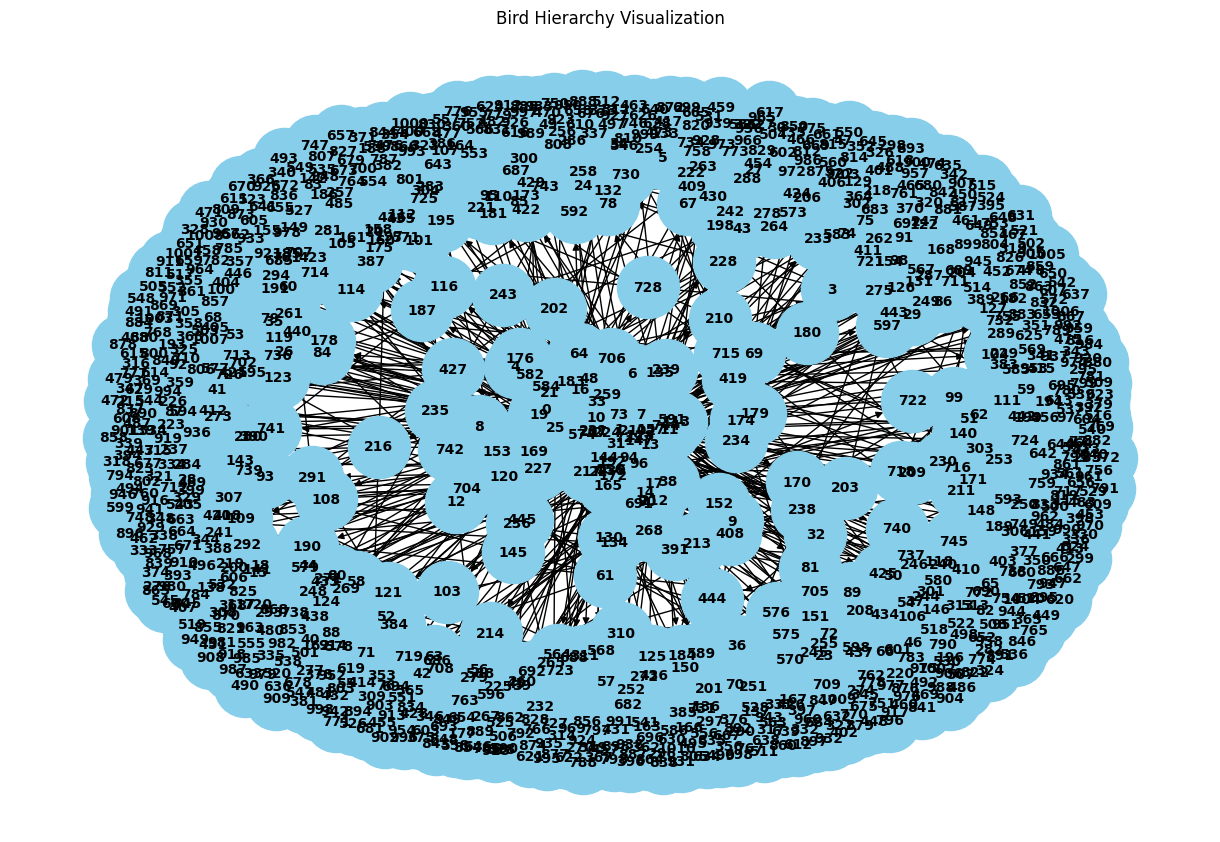


Hierarchy Dictionary:
Parent 0: Children [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Parent 11: Children [23, 26, 30, 35, 39, 46, 50, 56, 59, 65, 70, 78, 82, 86, 91, 97, 100, 106, 114, 117, 121, 126, 129, 146, 149, 154, 158]
Parent 1: Children [24, 27, 33, 36, 42, 51, 57, 60, 67, 72, 81, 87, 92, 98, 102, 109, 116, 122, 128, 130, 147, 153, 159, 161, 168, 174, 179, 181, 187, 192, 201, 203, 209, 214, 219, 225, 229, 235, 238]
Parent 22: Children [25, 32, 38, 48, 55, 64, 69, 80, 89, 96, 101, 113, 119, 125, 143, 151, 156, 165, 172, 178, 183, 189, 199, 207, 212, 217, 227, 231, 236]
Parent 8: Children [28, 40, 53, 66, 83, 93, 108, 120, 135, 155, 166, 175, 186, 202, 210, 224, 234]
Parent 7: Children [29, 41, 58, 71, 85, 99, 115, 127, 148, 160, 173, 184, 198, 208, 223, 233]
Parent 21: Children [31, 47, 63, 79, 95, 112, 124, 150, 164, 177, 188, 206, 216, 230]
Parent 19: Children [34, 52, 68, 90, 107, 123, 152, 167, 180, 200, 213, 228]
Parent 17: Children [37, 

In [72]:
import networkx as nx

with open('/Users/206509/CU/machine-learning/deep-learning/birds/hierarchy.txt', 'r') as file:
    data = file.readlines()

#parse the data into a df
lines = [line.split() for line in data]
hierarchy_df = pd.DataFrame(lines, columns=['child', 'parent'])
hierarchy_df['child'] = hierarchy_df['child'].astype(int)
hierarchy_df['parent'] = hierarchy_df['parent'].astype(int)

#create a dict for the hierarchy
hierarchy_dict = {}
for _, row in hierarchy_df.iterrows():
    child = int(row['child'])  # Convert to int
    parent = int(row['parent'])  # Convert to int
    
    if parent not in hierarchy_dict:
        hierarchy_dict[parent] = []
    
    hierarchy_dict[parent].append(child)

#create a directed graph
G = nx.DiGraph()
for _, row in hierarchy_df.iterrows():
    G.add_edge(row['parent'], row['child'])
pos = nx.spring_layout(G)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, node_color="skyblue", font_weight="bold", arrows=True)
plt.title("Bird Hierarchy Visualization")
plt.show()

#display the hierarchy dictionary
print("\nHierarchy Dictionary:")
for parent, children in hierarchy_dict.items():
    print(f"Parent {parent}: Children {children}")

Very complex! The good news is, values 1 through 22 are a clean layer — all of the other subcategories roll up to them, and they only roll up to category 0 ("Birds"). We can call these "supercategories" and create a new factor in the dataset for them.

In [35]:
#function to find supercategories for birds data
def find_supercategory(species_id):
    try:
        current_id = int(species_id)  #ensure the current_id is an int
    except ValueError:
        return None 

    while current_id != -1 and current_id not in range(1, 23):  #check if current_id is already a supercategory
        found_parent = False
        
        #iterate over the parent-child relationships in the hierarchy
        for parent, children in hierarchy_dict.items():
            if current_id in children:  
                current_id = parent  #set the current_id to its parent
                found_parent = True
            
        if not found_parent:
            print(f"Error: {current_id} not found in any children list")
            return None  #if no parent was found, return None

    return current_id  #return the supercategory

#create the supercategory column in the birds df if species_id is not null
df['supercategory'] = df['species_id'].apply(lambda x: find_supercategory(x) if pd.notnull(x) else None)

#display the updated dataframe
print(df[['species_id', 'supercategory']])

        species_id  supercategory
0            817.0           22.0
1            860.0           22.0
2            900.0           22.0
3            645.0            4.0
4            929.0           22.0
...            ...            ...
108557         NaN            NaN
108558         NaN            NaN
108559         NaN            NaN
108560         NaN            NaN
108561         NaN            NaN

[108562 rows x 2 columns]


Great, looks like it worked. Let's check our value counts to make sure we only have values for 1 through 22 (and -1 for not-birds) in Supercategory now.

In [36]:
df['supercategory'].value_counts()

0         22.0
1         22.0
2         22.0
3          4.0
4         22.0
          ... 
108557     NaN
108558     NaN
108559     NaN
108560     NaN
108561     NaN
Name: supercategory, Length: 108562, dtype: float64

In [37]:
#change the -1s back to nulls
df['supercategory'] = df['supercategory'].replace(-1, np.nan)

#verify the result
print(df[['species_id', 'supercategory']])

        species_id  supercategory
0            817.0           22.0
1            860.0           22.0
2            900.0           22.0
3            645.0            4.0
4            929.0           22.0
...            ...            ...
108557         NaN            NaN
108558         NaN            NaN
108559         NaN            NaN
108560         NaN            NaN
108561         NaN            NaN

[108562 rows x 2 columns]


Great! Now we can try training our `kind-of-bird` model on `supercategory` instead of `species_id.` We can use the same CNN we created for the categorical species classification data, but we will need to modify it for the `supercategory` classes instead — the output layer will need to be changed from 555 categories to just 22.

Let's go ahead and make a dictionary that associates `supercategory` values with the actual class names. This will be useful later when we write a program.

In [40]:
supercategory_to_class = {1: 'Ducks, Geese, and Swans', 2: 'Grouse, Quail, and Allies', 3: 'Loons', 4: 'Grebes', 5: 'Storks',
    6: 'Frigatebirds, Boobies, Cormorants, Darters, and Allies', 7: 'Pelicans, Herons, Ibises, and Allies', 
    8: 'Hawks, Kites, Eagles, and Allies', 9: 'Caracaras and Falcons', 10: 'Cranes and Rails', 11: 'Plovers, Sandpipers, and Allies',
    12: 'Skuas and Alcids', 13: 'Gulls, Terns, and Allies', 14: 'Pigeons and Doves', 15: 'Parrots', 16: 'Cuckoos', 17: 'Owls',
    18: 'Nightjars', 19: 'Swifts and Hummingbirds', 20: 'Kingfishers and Allies', 21: 'Woodpeckers', 22: 'Perching Birds'}

In [54]:
#create new class CNN
num_class = len(df['supercategory'].value_counts())

def create_class_prediction_model(num_class):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_class, activation='softmax'))  #multi-class classification
    return model

class_prediction_model = create_class_prediction_model(num_class)
class_prediction_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#prep training data for class prediction (only for birds)
train_class_data = train_data[train_data['is_bird'] == 1]

#stack image arrays
X_train_class = np.stack(train_class_data['image_array'].values)

y_train_class = train_class_data['supercategory'].values - 1 #to reflect a starting value of 0
y_train_class = tf.keras.utils.to_categorical(y_train_class, num_classes=22)

#train the class prediction model
class_prediction_history = class_prediction_model.fit(X_train_class, y_train_class, epochs=10, batch_size=8, validation_split=0.2)

class_prediction_acc = class_prediction_history.history['accuracy']
class_prediction_val_acc = class_prediction_history.history['val_accuracy']

Epoch 1/10


/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5005 - loss: 1.9573 - val_accuracy: 0.5376 - val_loss: 1.6926
Epoch 2/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5316 - loss: 1.7002 - val_accuracy: 0.5593 - val_loss: 1.6376
Epoch 3/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5538 - loss: 1.5839 - val_accuracy: 0.5733 - val_loss: 1.5643
Epoch 4/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.5759 - loss: 1.4790 - val_accuracy: 0.5951 - val_loss: 1.4959
Epoch 5/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6027 - loss: 1.3769 - val_accuracy: 0.5963 - val_loss: 1.4605
Epoch 6/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6247 - loss: 1.2963 - val_accuracy: 0.5901 - val_loss: 1.4858
Epoch 7/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6449 - loss: 1.1873 - val_accuracy: 0.6032 - val_loss: 1.4523
Epoch 8/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.6648 - loss: 1.1075 - val

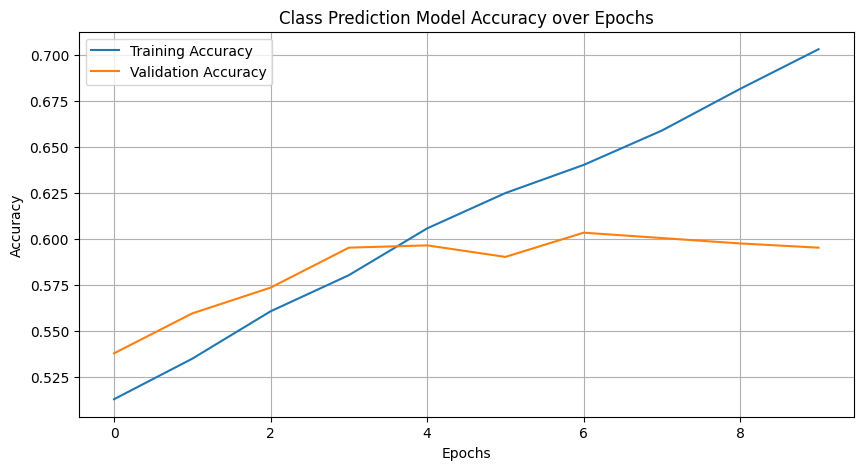

In [55]:
class_prediction_train_acc = class_prediction_history.history['accuracy']
class_prediction_val_acc = class_prediction_history.history['val_accuracy']
plot_accuracy(class_prediction_train_acc, class_prediction_val_acc, 'Class Prediction Model')

Definitely much better with the supercategories than the species, but the validation accuracy is plateauing around 60 percent. Let's try a couple of fine-tuning steps — adding L2 regularization and a dropout layer, as well as early stopping. I'm also going to cut the learning rate in half (from .001 to .0005) and implement the feature to reduce it on plateau.

In [56]:
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

class_prediction_model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.0005)))
class_prediction_model.add(Dropout(0.5))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_prediction_history_v2 = class_prediction_model.fit(X_train_class, y_train_class,
                                                       epochs=10,
                                                       batch_size=8,
                                                       validation_split=0.2,
                                                       callbacks=[early_stopping, reduce_lr])

Epoch 1/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7264 - loss: 0.8660 - val_accuracy: 0.5769 - val_loss: 1.6394 - learning_rate: 0.0010
Epoch 2/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7597 - loss: 0.7664 - val_accuracy: 0.5896 - val_loss: 1.7838 - learning_rate: 0.0010
Epoch 3/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7736 - loss: 0.7117 - val_accuracy: 0.5830 - val_loss: 1.8860 - learning_rate: 0.0010
Epoch 4/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8017 - loss: 0.6173 - val_accuracy: 0.5612 - val_loss: 2.0114 - learning_rate: 0.0010
Epoch 5/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8630 - loss: 0.4252 - val_accuracy: 0.5815 - val_loss: 2.1933 - learning_rate: 2.0000e-04
Epoch 6/10
2393/2393 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8961 - loss: 0.3340 - val_accuracy: 0.5777 - val_loss: 2.3713 - learning_rate: 2.0000e-04


The training accuracy is improving, but test validation isn't. This model is not as good as I would like it to be in a perfect world, but given the complexity of the task I think we can live with it.

<h2>A Program to Bring Everything Together</h2>

It's time to try to recreate the story!

This will be a four-step task: 

First, input `image_array` from the second image and reshape it as needed. Second, binary classification (for the "bird or not?" step) using a CNN, with sigmoid classification at the output layer because it's a binary result. Third, multiclass classification (for the species prediction for both images) using a separate CNN architecture with a softmax layer. Fourth, a comparison to see if the two predicted species are the same.

Hi, baby bird. Show me a photo of you:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/baby-sparrow.jpg
Show me what you think might be your mother:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/kitten.jpg


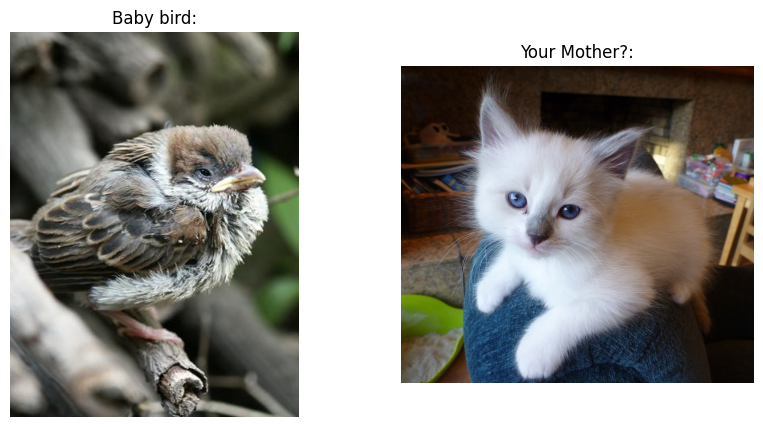

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
This is not your mother. This is not a bird.


In [82]:
import matplotlib.image as mpimg

def process_image(image_path):
    image_array = load_and_preprocess_image(image_path)
    image_array = rescale_image_array(image_array)
    return image_array

def display_images(image_path1, image_path2, title1="Image 1", title2="Image 2"):
    #load images from the provided paths
    image1 = mpimg.imread(image_path1)
    image2 = mpimg.imread(image_path2)

    #create a figure with two subplots, display both images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image1)
    axes[0].axis('off')  # Hide axes
    axes[0].set_title(title1)

    axes[1].imshow(image2)
    axes[1].axis('off')  # Hide axes
    axes[1].set_title(title2)

    plt.show()

def main():
    #step 1: take input images from the user
    bird_image_path = input("Hi, baby bird. Show me a photo of you: ")
    other_image_path = input("Show me what you think might be your mother: ")

    #display the images
    display_images(bird_image_path, other_image_path, title1="Baby bird:", title2="Your Mother?:")

    #step 2: process images into (1, 32, 32, 3) numpy arrays
    bird_image = process_image(bird_image_path)
    other_image = process_image(other_image_path)

    bird_image = np.expand_dims(bird_image, axis=0)  #shape (1, 32, 32, 3)
    other_image = np.expand_dims(other_image, axis=0)

    #step 3: predict with binary classification model
    binary_prediction = bird_or_not_model.predict(other_image)
    is_bird = np.round(binary_prediction[0][0])  # Assuming binary output

    if is_bird == 0:
        print("This is not your mother. This is not a bird.")
        return

    #step 4: predict with softmax model
    softmax_prediction_other = class_prediction_model.predict(other_image)
    softmax_prediction_bird = class_prediction_model.predict(bird_image)

    #get supercategory predictions and add 1
    supercategory_other = np.argmax(softmax_prediction_other) + 1
    supercategory_bird = np.argmax(softmax_prediction_bird) + 1

    #step 5: compare predictions
    class_name_other = supercategory_to_class[supercategory_other]
    class_name_bird = supercategory_to_class[supercategory_bird]

    if supercategory_other == supercategory_bird:
        print(f"This might be your mother!")
    else:
        print(f"I don't think this is your mother. You appear to be a {class_name_other} class, and this bird appears to be a {class_name_bird} class.")

if __name__ == "__main__":
    main()

Hi, baby bird. Show me a photo of you:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/baby-sparrow.jpg
Show me what you think might be your mother:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/dog.jpg


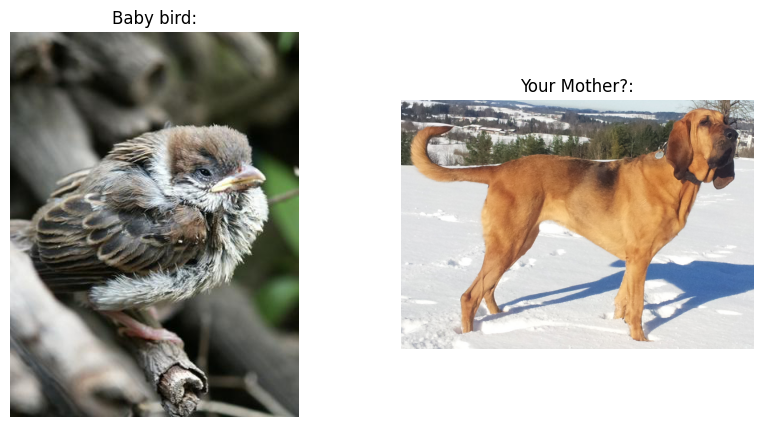

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
This is not your mother. This is not a bird.


In [83]:
if __name__ == "__main__":
    main()

Hi, baby bird. Show me a photo of you:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/baby-sparrow.jpg
Show me what you think might be your mother:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/vulture.jpg


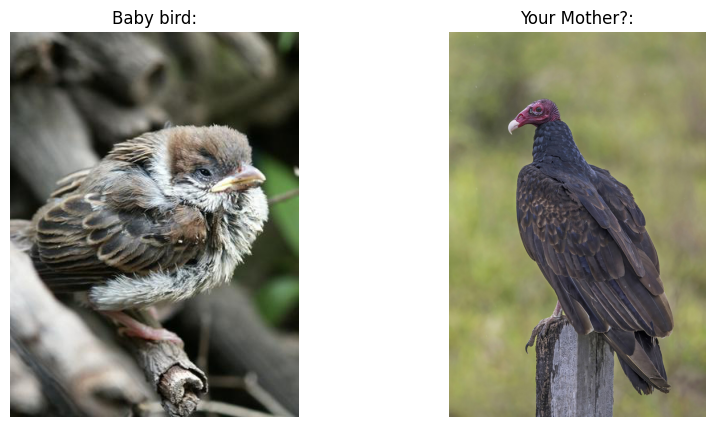

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
I don't think this is your mother. You appear to be a Woodpeckers class, and this bird appears to be a Storks class.


In [84]:
if __name__ == "__main__":
    main()

Hi, baby bird. Show me a photo of you:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/baby-sparrow.jpg
Show me what you think might be your mother:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/boat.jpg


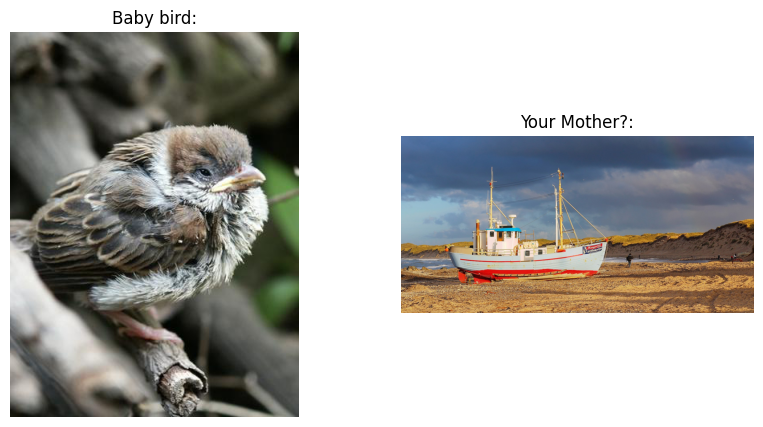

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
This is not your mother. This is not a bird.


In [86]:
if __name__ == "__main__":
    main()

Hi, baby bird. Show me a photo of you:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/baby-sparrow.jpg
Show me what you think might be your mother:  /Users/206509/CU/machine-learning/deep-learning/birds/are-you/sparrow.jpg


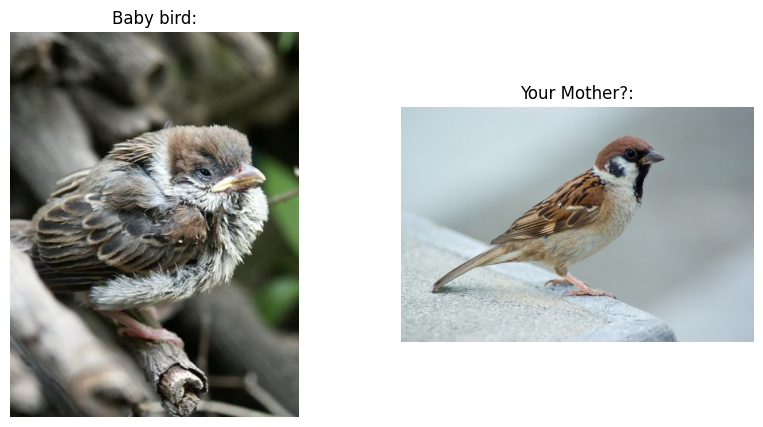

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
This might be your mother!


In [87]:
if __name__ == "__main__":
    main()

<h2>Results, Discussion and Conclusions</h2>

We've been plotting accuracy as we go along, but here's a summary results table for the models we tried:

In [63]:
histories = {"Bird or Not": bird_or_not_history, "Tuned Bird or Not": bird_or_not_history_v2, "Species Prediction": 
            species_prediction_history, "Tuned Species Prediction": species_prediction_history_v2, "Class Prediction": 
            class_prediction_history, "Tuned Class Prediction": class_prediction_history_v2}

def summarize_history(histories):
    summary_data = []

    for model_name, history in histories.items():
        #extract the final accuracy and loss for training and validation
        final_train_accuracy = history.history['accuracy'][-1]
        final_val_accuracy = history.history['val_accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        epochs = len(history.history['accuracy'])

        summary_data.append({
            "Model": model_name,
            "Epochs": epochs,
            "Final Training Accuracy": final_train_accuracy,
            "Final Validation Accuracy": final_val_accuracy,
            "Final Training Loss": final_train_loss,
            "Final Validation Loss": final_val_loss
        })

    #convert the list of data to a df
    summary_df = pd.DataFrame(summary_data)

    return summary_df

summary_results = summarize_history(histories)
print(summary_results)

                      Model  Epochs  Final Training Accuracy  \
0               Bird or Not      10                 0.950780   
1         Tuned Bird or Not      10                 0.980777   
2        Species Prediction      10                 0.123753   
3  Tuned Species Prediction      40                 0.792248   
4          Class Prediction      10                 0.702972   
5    Tuned Class Prediction       6                 0.891396   

   Final Validation Accuracy  Final Training Loss  Final Validation Loss  
0                   0.958880             0.125421               0.111345  
1                   0.928175             0.050273               0.252047  
2                   0.057668             4.307461               5.571542  
3                   0.052236             0.761753              18.717360  
4                   0.595069             0.972054               1.543242  
5                   0.577727             0.345341               2.371257  


Overall, the binary classification model performed much better than the multiclass model. This isn't surprising — we had similar numbers (around 50k and around 60k) of images at our disposal for each, and I think it's much easier to tell the difference between totally dissimilar images (bird vs. anything else) than it is to tell the difference between more-similar things (two different kinds of birds). Overfitting was a real problem with the multiclass set, which could be potentially be helped by more hyperparameter tuning or by more data — the train/test split already provided by the data was 50/50, but with more time I might have liked to experiment with moving some of the images from the test set into the training set. 

The eventual program wasn't perfect — I had to sub out a vulture for the hen from the story, for instance, because it turns out chickens weren't included in the birds training data. And it predicted the wrong category for both the baby sparrow (should be a perching bird, not a woodpecker) and the vulture (should not be a stork). But it did a great job of telling when something was not a bird, and it did eventually return a positive comparison between the sparrow and baby sparrow.

If I had more time and more computing power, it would also be nice to use a different, larger set of random images for the binary classifier and then not have to reduce the bird images quite as much — 32x32 pixels doesn't give you a ton of room for nuance in features. I think if I did that, then I could experiment with a deeper or more expert way of rolling up the species data. Ideally it would be great to return a species in the final "Are You My Mother" prediction, not a class as we ended up doing.

<h2>Citations</h2>

Bird image data provided by the Cornell Lab of Ornithology, with thanks to photographers and contributors of crowdsourced data at AllAboutBirds.org/Labs. This material is based upon work supported by the National Science Foundation under Grant No. 1010818. The dataset and more information can be found [here](https://dl.allaboutbirds.org/nabirds).

Random images are from CIFAR-100, a subset of the 80 Million Tiny Images dataset. This tech report describes the dataset and methodology: [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

"Are You My Mother" is by P.D. Eastman, copyright 1960. Read it [here](https://readwj.wordpress.com/wp-content/uploads/2023/03/are-you-my-mother.pdf).